# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Данные находятся в трёх файлах:

    gold_recovery_train.csv — обучающая выборка
    gold_recovery_test.csv — тестовая выборка
    gold_recovery_full.csv — исходные данные
    
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

**Инструкция по выполнению проекта**

**1. Подготовьте данные**

- 1.1. Откройте файлы и изучите их.
- 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
- 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- 1.4. Проведите предобработку данных.

**2. Проанализируйте данные**

- 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
- 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
- 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

**3. Постройте модель**

- 3.1. Напишите функцию для вычисления итоговой sMAPE.
- 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

## Подготовка данных

### Откройте файлы и изучите их.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
import joblib

pd.set_option('display.max_columns', None)

In [47]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col = 'date')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col = 'date')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col = 'date')

Изучим исходные данные.

In [3]:
display(data_full.head())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [4]:
display(sorted(data_train.columns))
data_train.describe()

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floa

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

In [5]:
display(sorted(data_test.columns))
display(data_test.describe())

['primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

### Вывод
Всего представлено 3 датасета: обучающий, тестовый и полный. Как видно исходные датасеты содержат пропущенные значения, также тестовый датасет содержит меньшее кол-во признаков, чем обучающая выборка и полная выборка. Необходимо исследовать какие признаки отствутвуют в тестовом наборе и разобраться почему. Также необходимо обработать пропуски у признаков, которые будут использоваться в обучении моделей.

### Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [6]:
# recovery  = 100*(C*(F-T)/F/(C-T)) - формула для расчета эффективности обогащения 
# C — доля золота в концентрате после флотации/очистки;
# F — доля золота в сырье/концентрате до флотации/очистки;
# T — доля золота в отвальных хвостах после флотации/очистки

C_rougher = data_train['rougher.output.concentrate_au']
T_rougher = data_train['rougher.output.tail_au']
F_rougher = data_train['rougher.input.feed_au']


data_train['rougher.output.recovery_calculated'] = 100*(C_rougher*(F_rougher-T_rougher)/F_rougher/(C_rougher-T_rougher))
print(data_train['rougher.output.recovery_calculated'].describe())

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery_calculated, dtype: float64


#### Комментарий
Эффективность обогащения принимает неадекватные значения, такие как -inf,+inf и т.д. Возможно для начала стоит провести обработку пропусков в столбце rougher.output.recovery

In [7]:
print(data_train['rougher.output.recovery'].describe())
print(data_train['rougher.output.recovery'].isna().sum())

count    14149.000000
mean        82.704502
std         14.479156
min          0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery, dtype: float64
0


In [8]:
data_train.dropna(subset = ['rougher.output.recovery'],inplace = True)

#### Комментарий
Целевой признак содержит пропущенные значения, для того, чтобы обучить модель необходимо избавиться от таких данных, следовательно было решено удалить строки содержащие пропущенные значения rougher.output.recovery - таких строк оказалось 2573. 

In [9]:
C_rougher = data_train['rougher.output.concentrate_au']
T_rougher = data_train['rougher.output.tail_au']
F_rougher = data_train['rougher.input.feed_au']


data_train['rougher.output.recovery_calculated'] = 100*(C_rougher*(F_rougher-T_rougher)/F_rougher/(C_rougher-T_rougher))
print(data_train['rougher.output.recovery_calculated'].describe())

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
Name: rougher.output.recovery_calculated, dtype: float64


#### Комментарий
После удаления строк с пропущенными значениями в столбце rougher.output.recovery, рассчитанные значения эффективности приняли адекватные пределы от 0 до 100, что свидетельсвует о том, что пропуски в этом столбце и неадекватные значения полученные ранее связаны между собой и могли быть вызваны тем, что в формуле для расчета эффективности обогащения присутствовало деление на 0.

Сравним рассчитание эффективности обогащения с полученными данными.

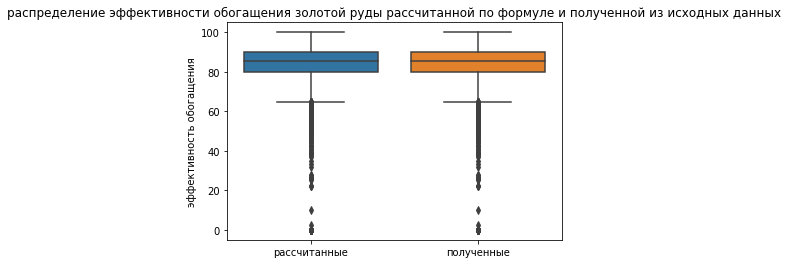

In [10]:
ax = sns.boxplot(data=pd.DataFrame({'рассчитанные':data_train['rougher.output.recovery_calculated'], 'полученные':data_train['rougher.output.recovery']}))
plt.ylabel('эффективность обогащения')
plt.title('распределение эффективности обогащения золотой руды рассчитанной по формуле и полученной из исходных данных')
plt.show()


In [11]:
print(data_train['rougher.output.recovery_calculated'].mean())
print(data_train['rougher.output.recovery'].mean())

print('MAE: {}'.format(mean_absolute_error(data_train['rougher.output.recovery_calculated'],data_train['rougher.output.recovery'])))

82.70450164550293
82.70450164550293
MAE: 1.0748911125799084e-14


#### Вывод
Эффективность обогащения рассчитана верно, о чем свидетельвует график распредления, а также метрика MAE очень мала.

### Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [12]:
k = 0
for train in data_train.columns:
    if train not in data_test.columns:
        k = k + 1
        print(train)
print(k)

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

#### Комментарий 
В тестовой выборке недоступны признаки с параметром output и calculation, вероятно это связано с тем, что эти признаки рассчитываются или получаются позже. Это означает, что для использования в обучающей выборке эти признаки не подходят и от них надо будет избавиться. Также для тестовой выборки из полной выборки надо добавить значения целевых признаков final.output.recovery и rougher.output.recovery.

### Проведите предобработку данных.

В тестовую выборку добавляются целевые признаки из полной выборки. В тестовой и обучающей выборке удалим строки у которых пропущены целевые признаки.

In [13]:
# final.output.recovery
# rougher.output.recovery

data_test[['final.output.recovery','rougher.output.recovery']] = data_full[['final.output.recovery','rougher.output.recovery']]

data_test.dropna(subset = ['rougher.output.recovery','final.output.recovery'],inplace = True)
data_train.dropna(subset = ['final.output.recovery'],inplace = True)

In [14]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_calculated
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000

Исследуем кол-во пропусков и заполним пропущенные значения ближайшими непропущенными значениями, которые встретились. Такой подход может быть корректным, если учесть, что "Соседние по времени параметры часто похожи".

In [15]:
print('Кол-во пропусков в обучающей выборке:')
display(data_train.isna().sum().sort_values(ascending = False).head(10))
print('Кол-во пропусков в тестовой выборке:')
display(data_test.isna().sum().sort_values(ascending = False).head(10))

Кол-во пропусков в обучающей выборке:


secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
primary_cleaner.input.xanthate               100
rougher.input.feed_pb                        100
final.output.tail_pb                         100
dtype: int64

Кол-во пропусков в тестовой выборке:


rougher.input.floatbank11_xanthate          25
rougher.input.feed_sol                      21
secondary_cleaner.state.floatbank3_a_air     9
rougher.input.floatbank11_sulfate            8
primary_cleaner.input.depressant             5
rougher.input.floatbank10_sulfate            5
primary_cleaner.input.sulfate                4
primary_cleaner.input.xanthate               4
rougher.input.feed_rate                      3
secondary_cleaner.state.floatbank2_a_air     3
dtype: int64

In [16]:
data_train = data_train.fillna(method = 'ffill')
data_test = data_test.fillna(method = 'ffill')

In [17]:
data_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_calculated
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
2016-01-15 01:00:00,6.02

## Анализ данных

### Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

In [18]:
data_train.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

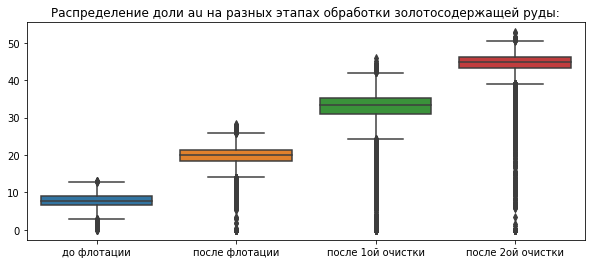

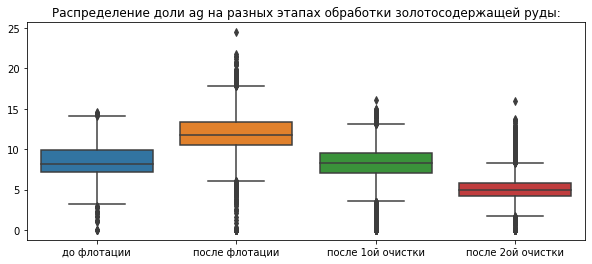

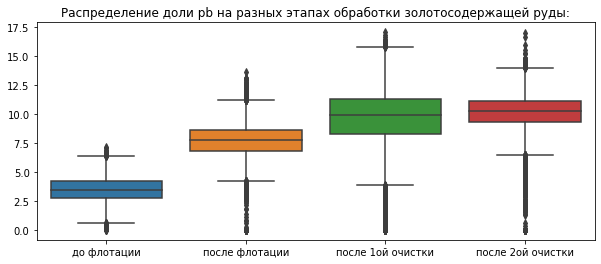

In [19]:
for met in ['au','ag','pb']:
    plt.figure(figsize=(10,4))
    ax = sns.boxplot(data=
                 pd.DataFrame({'до флотации':data_train['rougher.input.feed_{}'.format(met)], 
                               'после флотации':data_train['rougher.output.concentrate_{}'.format(met)],
                               'после 1ой очистки':data_train['primary_cleaner.output.concentrate_{}'.format(met)],
                               'после 2ой очистки':data_train['final.output.concentrate_{}'.format(met)]
                              }),)


    plt.title('Распределение доли {} на разных этапах обработки золотосодержащей руды:'.format(met))
    plt.show()

#### Комментарий
Графики показывают как меняется концентрации содержания металлов: Au, Ag, Pb на различных этапах обработки руды.
- Доля золота заметно увеличивается с каждым этапом в результате очистки.

- Доля серебра увеличивается после флотации, а затем падает, видимо в результате 1ой и 2ой очистки часть попадает в "хвосты".

- Доля свинца растет в результате флотации, но после 1ой и 2ой очистки примерно сохраняет свой уровень.

###  Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

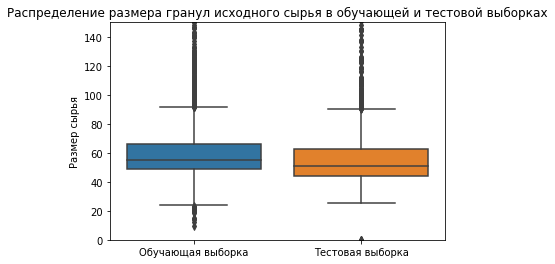

In [20]:
ax = sns.boxplot(data=pd.DataFrame({'Обучающая выборка':data_train['rougher.input.feed_size'], 'Тестовая выборка':data_test['rougher.input.feed_size']}))
plt.ylabel('Размер сырья')
plt.ylim(0,150)
plt.title('Распределение размера гранул исходного сырья в обучающей и тестовой выборках')
plt.show()


In [21]:
print('Размер гранул сырья на обучающей выборке: ')
display(data_train['rougher.input.feed_size'].describe())
print('Размер гранул сырья на тестовой выборке: ')
display(data_test['rougher.input.feed_size'].describe())

Размер гранул сырья на обучающей выборке: 


count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Размер гранул сырья на тестовой выборке: 


count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

#### Комментарий
Оба распределния имеют смещение в сторону малых размеров гранул сырья, но при этом можно заметить, что среднее и медиана размера гранул сырья для тестовой выборки меньше ~10%, чем для обучающей выборки. Но такие отличия не должны быть столь существенны на корректность работы модели.

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

Рассчитаем суммарную концентрацию веществ на разных стадиях

In [22]:
#суммараная начальная концентрация материалов в сырье на обуч.выборке
before_floct = data_train['rougher.input.feed_au']+data_train['rougher.input.feed_ag']+data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_sol']
#суммараная начальная концентрация материалов в сырье на тест.выборке
before_floct_test = data_test['rougher.input.feed_au']+data_test['rougher.input.feed_ag']+data_test['rougher.input.feed_pb']+data_test['rougher.input.feed_sol']
#суммараная концентрация материалов после флоктации в сырье на обуч.выборке
after_floct = data_train['rougher.output.concentrate_au']+data_train['rougher.output.concentrate_ag']+data_train['rougher.output.concentrate_pb']+data_train['rougher.output.concentrate_sol']
#суммараная концентрация материалов после 1ой очистки в сырье на обуч.выборке
after_first_clean =  data_train['primary_cleaner.output.concentrate_au']+data_train['primary_cleaner.output.concentrate_ag']+data_train['primary_cleaner.output.concentrate_pb']+data_train['primary_cleaner.output.concentrate_sol']
#суммараная концентрация материалов после 2ой очистки в сырье на обуч.выборке
after_second_clean = data_train['final.output.concentrate_au']+data_train['final.output.concentrate_ag']+data_train['final.output.concentrate_pb']+data_train['final.output.concentrate_sol']


Представим результаты в виде графиков

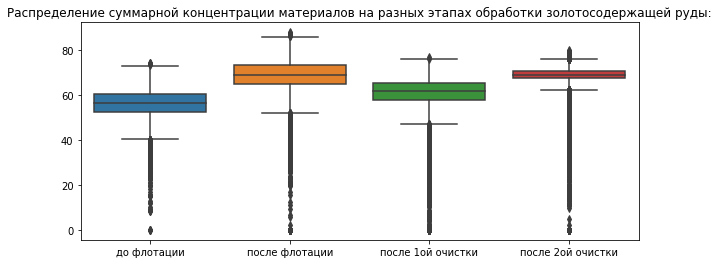

In [23]:
plt.figure(figsize=(10,4))
ax = sns.boxplot(data=
                 pd.DataFrame({'до флотации':before_floct, 
                               'после флотации':after_floct,
                               'после 1ой очистки':after_first_clean,
                               'после 2ой очистки':after_second_clean,
                              }),)


plt.title('Распределение суммарной концентрации материалов на разных этапах обработки золотосодержащей руды:')
plt.show()

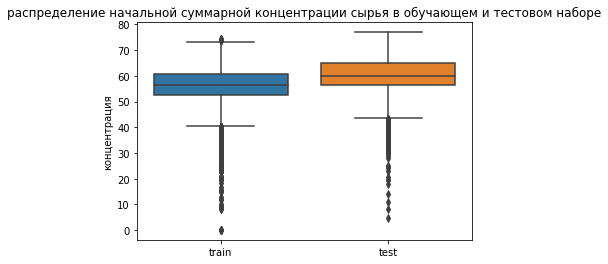

In [24]:
ax = sns.boxplot(data=pd.DataFrame({'train':before_floct, 'test':before_floct_test}))
plt.ylabel('концентрация')
plt.title('распределение начальной суммарной концентрации сырья в обучающем и тестовом наборе')
plt.show()

In [25]:
print('Кол-во строк у которых начальная суммарная концентрация менее 1:')
print(len(data_train[be
                     fore_floct<1][['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb','final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb']]))
data_train.drop(data_train[data_train['rougher.input.feed_au']+data_train['rougher.input.feed_ag']+data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_sol']<1].index, inplace = True)
print('Кол-во строк у которых начальная суммарная концентрация менее 1:')
print(len(data_train[data_train['rougher.input.feed_au']+data_train['rougher.input.feed_ag']+data_train['rougher.input.feed_pb']+data_train['rougher.input.feed_sol']<1][['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb','final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb']]))

Кол-во строк у которых начальная суммарная концентрация менее 1:
5
Кол-во строк у которых начальная суммарная концентрация менее 1:
0


#### Комментарий
Были построены графики распределения суммарных концентраций на различных этапах для обучающей выборки, а также распределения начальных суммарных концентраций для обучающей и тестовой выборок. Было замечено, что на обучающей выборке присутствуют данные у которых суммарные концентрации близки нулю, что свидетельсвует о явных аномалиях в данных, поэтому такие данные были удалены.

## Модель

Задача в этом пункте заключается в построение двух моделях:

1) предсказывает rougher.output.recovery. Она использует только признаки rougher. Использование только признаков rougher обусловлено тем, что признаки, которые относятся к этапам после флотации, не должны влиять на результат флотации.

2) предсказывает final.output.recovery. Она использует все признаки включая rougher.output.recovery. В данном случае используются все признаки т.к. будут важны все признаки, т.к. эффективность обогащения зависит от начальных параметров сырья.

Затем по предсказаниям наилучших моделей необходимо рассчитать метрику sMAPE.

### Напишите функцию для вычисления итоговой sMAPE.

In [25]:

def smape(predictions, target):
    return 100*1/len(predictions) * np.sum(2 * np.abs(target - predictions) / (np.abs(predictions) + np.abs(target)))



def final_smape(predictions_1, target_1, predictions_2, target_2):
    final_result = 0.25*smape(predictions_1, target_1) + 0.75*smape(predictions_2, target_2)
    return final_result

### Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

#### Подготовка признаков

Для обучения будут использоваться только те признаки, которые есть и на тестовой выборке.

In [30]:
data_train_filtered = data_train[data_test.columns]
print(data_train_filtered.columns)

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Теперь необходимо отобрать признаки для первой и второй модели. 

In [31]:
# Отбор признаков, которые содержат rougher в названии.
res = [col for col in data_train_filtered if col.startswith('rougher')]

# Признаки используемые для обучения модели, которая предсказывает 'rougher.output.recovery'
features_train_rougher = data_train_filtered[res].drop(['rougher.output.recovery'], axis = 1)
target_train_rougher = data_train_filtered['rougher.output.recovery']


# Признаки используемые для обучения модели, которая предсказывает 'final.output.recovery'
features_train_cleaner = data_train_filtered.drop(['rougher.output.recovery','final.output.recovery'], axis = 1)
target_train_cleaner = data_train_filtered['final.output.recovery']

# Признаки используемые для проверки модели, которая предсказывает 'rougher.output.recovery'
features_test_rougher = data_test[res].drop(['rougher.output.recovery'], axis = 1)
target_test_rougher = data_test['rougher.output.recovery']

# Признаки используемые для проверки модели, которая предсказывает 'final.output.recovery'
features_test_cleaner = data_test.drop(['rougher.output.recovery','final.output.recovery'], axis = 1)
target_test_cleaner = data_test['final.output.recovery']

Проведем стандратизацию признаков.

In [32]:
# Масштабирование признаков для модели 'rougher.output.recovery'
scaler_rougher = StandardScaler()
scaler_rougher.fit(features_train_rougher)
features_train_rougher =  scaler_rougher.transform(features_train_rougher)
features_test_rougher = scaler_rougher.transform(features_test_rougher)

# Масштабирование признаков для модели 'final.output.recovery'
scaler_cleaner = StandardScaler()
scaler_cleaner.fit(features_train_cleaner)
features_train_cleaner =  scaler_cleaner.transform(features_train_cleaner)
features_test_cleaner = scaler_cleaner.transform(features_test_cleaner)


Метрики для оценки моделей.

In [33]:
smape_score = make_scorer(smape, greater_is_better=False)
final_smape_score = make_scorer(final_smape, greater_is_better=False)


### Dummy-модель

Исследуем предсказания Dummy-модели, которая будет предсказывать медианное значение в для целевого признака.

In [34]:
dummy_regr_rougher = DummyRegressor(strategy="median")
dummy_regr_cleaner = DummyRegressor(strategy="median")
dummy_regr_rougher.fit(features_train_rougher, target_train_rougher)
dummy_regr_cleaner.fit(features_train_cleaner, target_train_cleaner)
dummy_predictions_rougher = dummy_regr_rougher.predict(features_test_rougher)
dummy_predictions_cleaner = dummy_regr_cleaner.predict(features_test_cleaner)

print('sMAPE: {:.2f}'.format(final_smape(dummy_predictions_rougher, target_test_rougher, dummy_predictions_cleaner, target_test_cleaner)))

sMAPE: 9.48


#### Вывод
Получена итоговая метрика sMAPE для dummy-моделей, которые используют медианные значения для предсказаний. Эта оценка будет использоваться для проверки качества моделей.

### Linear Regression

Перейдем к обучению модели линейной регрессии. 

In [35]:
model_rougher = LinearRegression()
model_cleaner = LinearRegression()
score_rougher = (cross_val_score(estimator = model_rougher, X = features_train_rougher,y = target_train_rougher, cv = 5,scoring=smape_score))
score_final = (cross_val_score(estimator = model_cleaner, X = features_train_cleaner,y = target_train_cleaner, cv = 5,scoring=smape_score))
print(score_rougher.mean(), score_final.mean())

-12.472324262880557 -12.245300320302261


In [36]:
model_rougher.fit(features_train_rougher, target_train_rougher)
model_cleaner.fit(features_train_cleaner, target_train_cleaner)
predictions_rougher = model_rougher.predict(features_test_rougher)
predictions_cleaner = model_cleaner.predict(features_test_cleaner)

In [37]:
print('sMAPE для rougher.output.recovery: {:.2f}'.format(smape(predictions_rougher, target_test_rougher)))
print('sMAPE для final.output.recovery: {:.2f}'.format(smape(predictions_cleaner, target_test_cleaner)))
print('Итоговая sMAPE: {:.2f}'.format(final_smape(predictions_rougher, target_test_rougher, predictions_cleaner, target_test_cleaner)))

sMAPE для rougher.output.recovery: 9.34
sMAPE для final.output.recovery: 10.06
Итоговая sMAPE: 9.88


#### Вывод
Были обучены модели линейной регрессии для предсказания 'rougher.output.recovery' и 'final.output.recovery' для них была получена итоговая метрика sMAPE. Ее значение больше, чем для моделей, которые предсказывают медианные значения целевых признаков, что свидетельсвует о том, что полученные модели линейной регрессии не подходят для решения данной задачи и необходимо рассмотреть другие модели.

####  Decision Tree Regressor

Попробуем дерево решений для нашей задачи. Зададим сетку параметров для использования решетчетого поиска при переборе гиперпараметров.

In [37]:
# сетка параметров для max_depth и max_features
param_grid = {'max_depth':[2,3,4,5,6,8,10,12,14,16],'max_features':[2,3,4,5,6,7,8,9,10]}

In [38]:
%%time
tree_grid_search_rougher = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid, cv=5, scoring = smape_score)
tree_grid_search_rougher.fit(features_train_rougher, target_train_rougher)
print(tree_grid_search_rougher.best_score_)
print(tree_grid_search_rougher.best_estimator_)

-10.883742377886318
DecisionTreeRegressor(max_depth=2, max_features=2, random_state=12345)
CPU times: user 24.9 s, sys: 0 ns, total: 24.9 s
Wall time: 24.9 s


In [39]:
%%time
tree_grid_search_cleaner = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid, cv=5, scoring = smape_score)
tree_grid_search_cleaner.fit(features_train_cleaner, target_train_cleaner)
print(tree_grid_search_cleaner.best_score_)
print(tree_grid_search_cleaner.best_estimator_)

-10.784863299704941
DecisionTreeRegressor(max_depth=4, max_features=7, random_state=12345)
CPU times: user 26 s, sys: 29.5 ms, total: 26.1 s
Wall time: 26.1 s


#### Комментарий
Для выбора наилучших гиперпараметров и перекрестной проверки был использован GridSearchCV. В результате были определены наилучшие модели и их гиперпараметры.

In [40]:
best_tree_grid_search_rougher = DecisionTreeRegressor(random_state = 12345, max_depth = 2, max_features = 2)
best_tree_grid_search_rougher.fit(features_train_rougher, target_train_rougher)
predictions_rougher = best_tree_grid_search_rougher.predict(features_test_rougher)

best_tree_grid_search_cleaner = DecisionTreeRegressor(random_state = 12345, max_depth = 3, max_features = 9)
best_tree_grid_search_cleaner.fit(features_train_cleaner, target_train_cleaner)
predictions_cleaner = best_tree_grid_search_cleaner.predict(features_test_cleaner)

In [41]:
print('sMAPE для rougher.output.recovery: {:.2f}'.format(smape(predictions_rougher, target_test_rougher)))
print('sMAPE для final.output.recovery: {:.2f}'.format(smape(predictions_cleaner, target_test_cleaner)))
print('Итоговая sMAPE: {:.2f}'.format(final_smape(predictions_rougher, target_test_rougher, predictions_cleaner, target_test_cleaner)))

sMAPE для rougher.output.recovery: 8.94
sMAPE для final.output.recovery: 9.88
Итоговая sMAPE: 9.65


#### Вывод
Для наилучших значений гиперпараметров на тестовой выборке была рассчитана метрика sMAPE. Итоговая smape стала меньше, чем для моделей линейной регрессии, но по качеству все равно отстает от моделей предсказывающих медианное значение.

####  Random Forrest Regressor

Исследуем какие результаты даст модель основанная на случайной лесе деревьев решений.

In [42]:
# сетка параметров для n_estimators, max_depth, max_features
param_grid = {'n_estimators': [10,20,30,40,50],'max_depth':[2,3,4,5,6,8,10,12,14,16],'max_features':[2,3,4,5,6,7,8,9,10]}

In [43]:
%%time
forrest_grid_search_rougher = GridSearchCV(RandomForestRegressor(random_state = 12345), param_grid, cv=5, scoring = smape_score)
forrest_grid_search_rougher.fit(features_train_rougher, target_train_rougher)
print(forrest_grid_search_rougher.best_score_)
print(forrest_grid_search_rougher.best_estimator_)

-11.281991743182951
RandomForestRegressor(max_depth=4, max_features=3, n_estimators=20,
                      random_state=12345)
CPU times: user 37min 55s, sys: 2.16 s, total: 37min 58s
Wall time: 37min 58s


In [44]:
%%time
forrest_grid_search_cleaner = GridSearchCV(RandomForestRegressor(random_state = 12345), param_grid, cv=5, scoring = smape_score)
forrest_grid_search_cleaner.fit(features_train_cleaner, target_train_cleaner)
print(forrest_grid_search_cleaner.best_score_)
print(forrest_grid_search_cleaner.best_estimator_)

-9.765691784266895
RandomForestRegressor(max_depth=4, max_features=9, n_estimators=10,
                      random_state=12345)
CPU times: user 39min 32s, sys: 2.85 s, total: 39min 35s
Wall time: 39min 36s


In [45]:
best_forrest_grid_search_rougher = RandomForestRegressor(random_state = 12345, max_depth = 4, max_features = 4,n_estimators = 10)
best_forrest_grid_search_rougher.fit(features_train_rougher, target_train_rougher)
predictions_rougher = best_forrest_grid_search_rougher.predict(features_test_rougher)

best_forrest_grid_search_cleaner = RandomForestRegressor(random_state = 12345, max_depth = 5, max_features = 9, n_estimators = 20)
best_forrest_grid_search_cleaner.fit(features_train_cleaner, target_train_cleaner)
predictions_cleaner = best_forrest_grid_search_cleaner.predict(features_test_cleaner)

In [46]:
print('sMAPE для rougher.output.recovery: {:.2f}'.format(smape(predictions_rougher, target_test_rougher)))
print('sMAPE для final.output.recovery: {:.2f}'.format(smape(predictions_cleaner, target_test_cleaner)))
print('Итоговая sMAPE: {:.2f}'.format(final_smape(predictions_rougher, target_test_rougher, predictions_cleaner, target_test_cleaner)))

sMAPE для rougher.output.recovery: 8.52
sMAPE для final.output.recovery: 9.20
Итоговая sMAPE: 9.03


#### Вывод
Аналогично как и для модели дерева решений использовался решетчатый поиск с кросс-проверкой при помощи GridSearchCV. По наилучшим значениям гиперпараметров были предсказаны целевые признаки для тестовой выборки. Полученная таким методом sMAPE показала наилучший результат.  

### Общий вывод
Таким образом, в ходе выполнения задания были решены все поставленные задачи. В качестве наилучших моделей были выбраны модели случайного леса. Метрика итоговая метрика sMAPE получилась равной 9.03, однако модели, заполняющие целевые признаки медианным значением показали результат 9.48.
Возможно для улучшения результатов предсказаний можно было воспользоваться другим методом обработки пропусков в данных, например, не заполнением ближашим значением, а построением модели.